# Asset Selection

In [19]:
import pandas as pd
import numpy as np

import scipy.stats as stats
from sklearn import covariance

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

import datetime as dt
import yfinance as yf

import matplotlib.pyplot as plt
import seaborn as sns

import random

jtplot.style(figsize=(15, 9))

In [2]:
tickers  = ['AMD', 'AMZN', 'BAC', 'META', 'AVGO', 'TER']
amounts  = [20, 10, 30, 10, 2, 5]
weights = [i / sum(amounts) for i in amounts]
returns = [f'{t}_returns' for t in tickers]

In [3]:
df = yf.download(tickers, dt.datetime(2023, 1, 1), dt.datetime.now(), auto_adjust=True)
df.head()

[*********************100%***********************]  6 of 6 completed


Close                                                          \
                  AMD       AMZN       AVGO        BAC        META        TER   
Date                                                                            
2023-01-03  64.019997  85.820000  53.716286  32.075710  124.484192  85.381950   
2023-01-04  64.660004  85.139999  54.372353  32.678749  127.108803  86.862442   
2023-01-05  62.330002  83.120003  53.865742  32.611744  126.679680  86.564354   
2023-01-06  63.959999  86.080002  57.108242  32.937191  129.753372  90.658081   
2023-01-09  67.239998  87.360001  55.988270  32.439449  129.204498  92.615517   

                 High                                   ...       Open  \
                  AMD       AMZN       AVGO        BAC  ...       AVGO   
Date                                                    ...              
2023-01-03  66.879997  86.959999  55.083747  32.630887  ...  54.834324   
2023-01-04  65.790001  86.980003  55.141007  33.329644  ...  54.639247   
2023-01-05  64.349998  85.419998  54.333534  32.678748  ...  53.932708   
2023-01-06  64.300003  86.400002  57.357665  33.099917  ...  54.651860   
2023-01-09  69.320000  89.480003  58.393702  33.272211  ...  57.483840   

                                                Volume                      \
                  BAC        META        TER       AMD      AMZN      AVGO   
Date                                                                         
2023-01-03  31.807696  122.568131  88.283325  46851800  76706000  20173140   
2023-01-04  32.449024  127.118777  86.683590  47477100  68885100  17073590   
2023-01-05  32.468163  125.871336  86.286133  46159500  67930800  16278850   
2023-01-06  32.630888  128.705522  87.716960  70161300  83303400  35261010   
2023-01-09  33.262640  130.891035  92.347242  69741300  65266100  37738740   

                                         
                 BAC      META      TER  
Date                                     
2023-01-03  35221500  35528500  1033200  
2023-01-04  41998500  32397100  2025400  
2023-01-05  34177000  25447100   998700  
2023-01-06  34068700  27584500  1444500  
2023-01-09  43818800  26649100  1654500  

[5 rows x 30 columns]

In [4]:
portfolio = pd.DataFrame(index=df.index, columns=tickers, data=0)

for ticker, amount in zip(tickers, amounts):
    portfolio[ticker] = df['Close'][ticker] * amount
    portfolio[f'{ticker}_returns'] = np.log(portfolio[ticker].div(portfolio[ticker].shift(1)))

portfolio.dropna(axis=0, inplace=True)
portfolio.head()

,AMD,AMZN,BAC,META,AVGO,TER,AMD_returns,AMZN_returns,BAC_returns,META_returns,AVGO_returns,TER_returns
Date,,,,,,,,,,,,
2023-01-04,1293.200073,851.399994,980.362473,1271.088028,108.744705,434.312210,0.009947,-0.007955,0.018626,0.020865,0.012140,0.017191
2023-01-05,1246.600037,831.200027,978.352318,1266.796799,107.731483,432.821770,-0.036700,-0.024012,-0.002053,-0.003382,-0.009361,-0.003438
2023-01-06,1279.199982,860.800018,988.115730,1297.533722,114.216484,453.290405,0.025815,0.034992,0.009930,0.023974,0.058454,0.046207
2023-01-09,1344.799957,873.600006,973.183479,1292.044983,111.976540,463.077583,0.050010,0.014760,-0.015227,-0.004239,-0.019806,0.021362
2023-01-10,1361.000061,898.700027,979.788094,1327.172699,111.596085,470.877571,0.011974,0.028327,0.006764,0.026825,-0.003403,0.016704


In [5]:
rates = ['^GSPC', '^TNX']
rates_df = yf.download(rates, dt.datetime(2023, 1, 1), dt.datetime.now(), auto_adjust=True)
rates_df = rates_df['Close']

rates_df['market_returns'] = np.log(rates_df['^GSPC'].div(rates_df['^GSPC'].shift(1)))
rates_df['risk_free_returns'] = np.log(rates_df['^TNX'].div(rates_df['^TNX'].shift(1)))

rates_df.dropna(inplace=True)
rates_df.head()

[*********************100%***********************]  2 of 2 completed


,^GSPC,^TNX,market_returns,risk_free_returns
Date,,,,
2023-01-04,3852.969971,3.709,0.007511,-0.022395
2023-01-05,3808.100098,3.720,-0.011714,0.002961
2023-01-06,3895.080078,3.569,0.022584,-0.041438
2023-01-09,3892.090088,3.517,-0.000768,-0.014677
2023-01-10,3919.250000,3.621,0.006954,0.029142


In [20]:
risk_free_rate = rates_df['risk_free_returns'].sum()
market_rate = rates_df['market_returns'].sum()
market_std = rates_df['market_returns'].std()
portfolio_std = portfolio[returns].sum(axis=1).std()
portfolio_returns = portfolio[returns].sum(axis=1).sum()

In [19]:
E_R_portfolio = risk_free_rate + (market_rate - risk_free_rate)*portfolio_std/market_std
E_R_portfolio

3.383569872523047

Text(0.08, 5.02, 'capital market line')

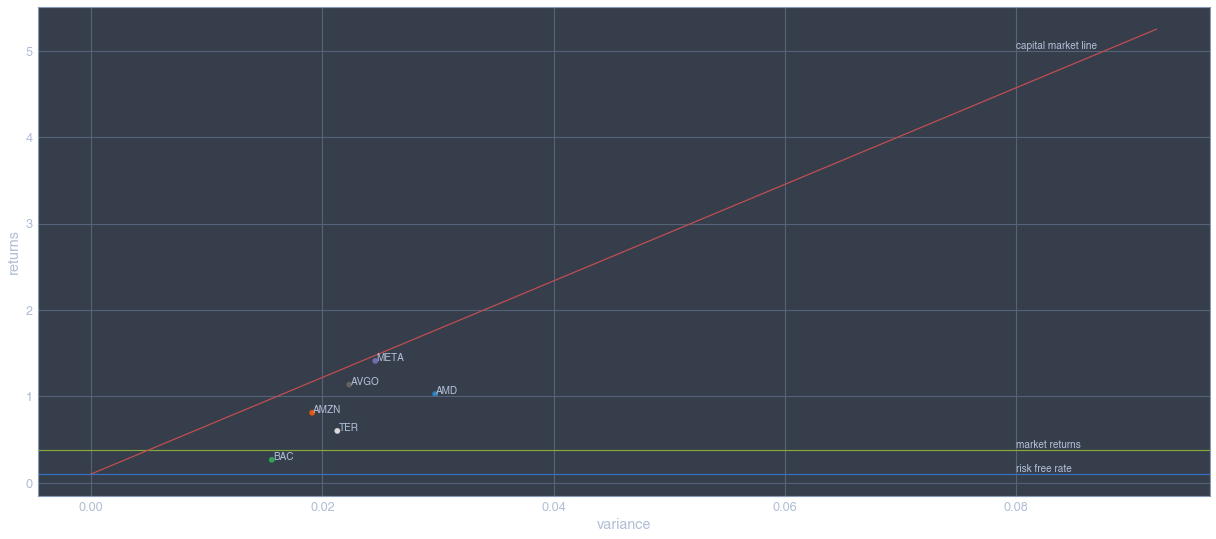

In [23]:
fig, ax = plt.subplots(1, figsize=(21, 9))

x = portfolio[returns].std().to_list()
y = portfolio[returns].sum().to_list()

ax.scatter(x, y, c=np.arange(6), cmap='tab20c')
ax.axhline(rates_df['risk_free_returns'].sum())
ax.axhline(rates_df['market_returns'].sum(), color='g')

ax.plot([0, portfolio_std], [risk_free_rate, portfolio_returns], c='r')

ax.set_xlabel('variance')
ax.set_ylabel('returns')

for i, ticker in enumerate(tickers):
    ax.annotate(ticker, (x[i], y[i]), xytext=(x[i]+0.0001, y[i]+0.0001))

ax.annotate('risk free rate', (0.08, 0.13))
ax.annotate('market returns', (0.08, 0.4))
ax.annotate('capital market line', (0.08, 5.02))

## Stationarity test

In [15]:
prft = portfolio[tickers].sum(axis=1)
prft_log = np.log(portfolio[tickers].sum(axis=1))

adftest_prft = adfuller(prft)
print('ADF for PORTFOLIO:')
print(f'ADF Statistic: {adftest_prft[0]}')
print(f'ADF p-value: {adftest_prft[1]}')
print('-------------------------')
print('ADF for log_PORTFOLIO:')
adftest_prft_log = adfuller(prft_log)
print(f'ADF Statistic: {adftest_prft_log[0]}')
print(f'ADF p-value: {adftest_prft_log[1]}')

ADF for PORTFOLIO:
ADF Statistic: -0.5714437389602783
ADF p-value: 0.8773049058780478
-------------------------
ADF for log_PORTFOLIO:
ADF Statistic: -1.5015462463660334
ADF p-value: 0.5327462947317076


In [18]:
adftest_prft_return = adfuller(portfolio[returns].sum(axis=1))
print('ADF for PORTFOLIO returns:')
print(f'ADF Statistic: {adftest_prft[0]}')
print(f'ADF p-value: {adftest_prft[1]}')

ADF for PORTFOLIO returns:
ADF Statistic: -14.927031017755453
ADF p-value: 1.3841611321148966e-27


In [32]:
for r in returns:
    adf_t = adfuller(portfolio[r])
    print(f'ADF for {r}:')
    print(f'ADF Statistic: {adf_t[0]}')
    print(f'ADF p-value: {adf_t[1]}')
    print('--------------')

ADF for AMD_returns:
ADF Statistic: -19.551307416562377
ADF p-value: 0.0
--------------
ADF for AMZN_returns:
ADF Statistic: -16.63605354646283
ADF p-value: 1.6501019898181052e-29
--------------
ADF for BAC_returns:
ADF Statistic: -17.569773280412917
ADF p-value: 4.0570516022231895e-30
--------------
ADF for META_returns:
ADF Statistic: -15.053258950708178
ADF p-value: 9.22799826496107e-28
--------------
ADF for AVGO_returns:
ADF Statistic: -17.64771878051087
ADF p-value: 3.732845757900357e-30
--------------
ADF for TER_returns:
ADF Statistic: -19.171547301126548
ADF p-value: 0.0
--------------


In [35]:
adf_t = portfolio[['AMD_returns', 'TER_returns']].sum(axis=1)
print(f'ADF for AMD_returns and TER_returns:')
print(f'ADF Statistic: {adf_t[0]}')
print(f'ADF p-value: {adf_t[1]}')

ADF for AMD_returns and TER_returns:
ADF Statistic: 0.027138363363589234
ADF p-value: -0.040137576302638936


<AxesSubplot:xlabel='Date'>

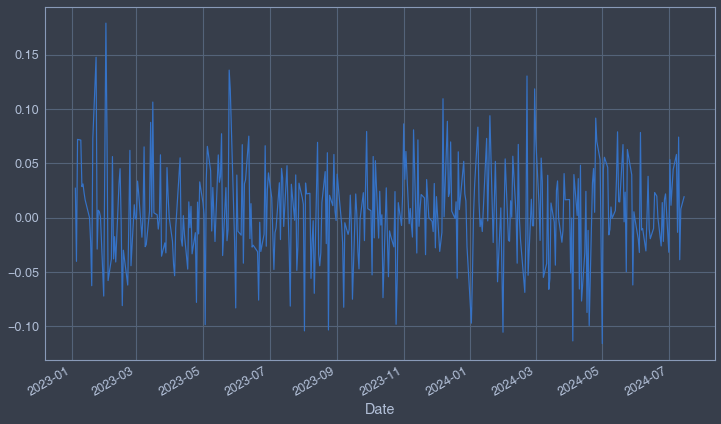

In [36]:
adf_t.plot()

## Decomposition

PORTFOLIO decomposition:


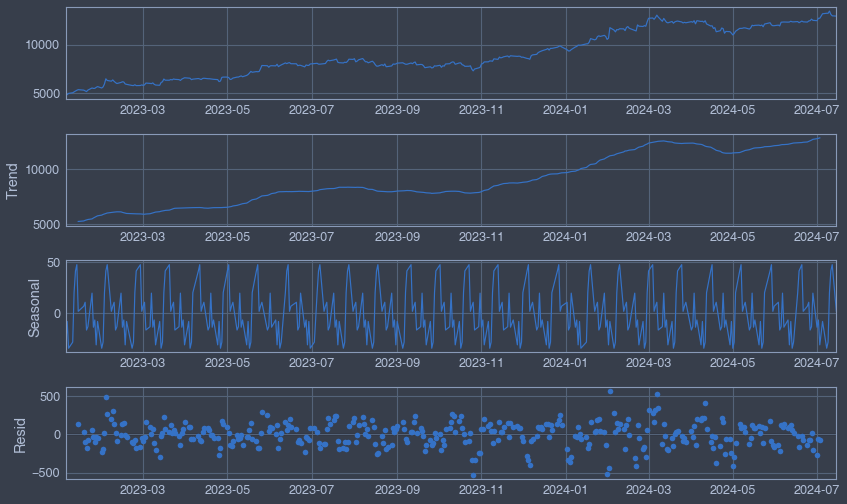

In [25]:
decomposition = sm.tsa.seasonal_decompose(prft, period=15, model='additive') 
figure = decomposition.plot()
print('PORTFOLIO decomposition:')

AMD_returns, TER_return decomposition:


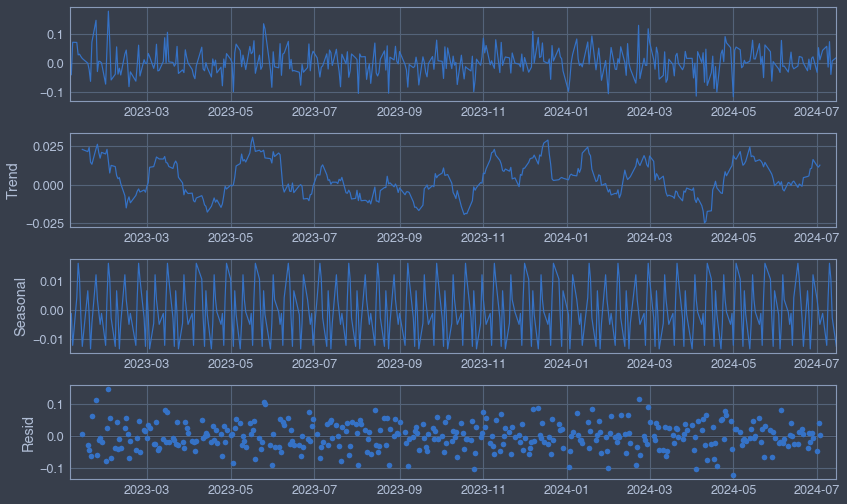

In [37]:
decomposition = sm.tsa.seasonal_decompose(portfolio[['AMD_returns', 'TER_returns']].sum(axis=1), period=15, model='additive') 
figure = decomposition.plot()
print('AMD_returns, TER_return decomposition:')